# The Blood Transfusion Service Center Dataset

The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.html) is a great resource for practicing your data science skills. They provide a wide range of datasets for testing machine learning algorithms. Finding a subject matter you're interested in can be a great way to test yourself on real-world data problems. Given our mission, we're interested in predicting if a blood donor will donate within a given time window.

Imports & Admin

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')


import seaborn as sns
sns.set_style('whitegrid')
sns.color_palette('pastel')
%matplotlib inline

Read Data

In [7]:
raw_data = pd.read_csv('C:\\Users\\green\\Documents\\udacity\\deep-learning-master\\intro-to-rnns//blood_donation_train.csv')
raw_data.columns.values[0] = 'id'  # Rename the first column (unnamed)
raw_data.columns = raw_data.columns.str.replace(' ', '_')  # Replace the spaces in the col names.

## Exploring the Data

Let’s take a quick look at this data


In [8]:
print(raw_data.shape)

(576, 6)


In [9]:
print(raw_data.head(10))

    id  Months_since_Last_Donation  Number_of_Donations  \
0  619                           2                   50   
1  664                           0                   13   
2  441                           1                   16   
3  160                           2                   20   
4  358                           1                   24   
5  335                           4                    4   
6   47                           2                    7   
7  164                           1                   12   
8  736                           5                   46   
9  436                           0                    3   

   Total_Volume_Donated_(c.c.)  Months_since_First_Donation  \
0                        12500                           98   
1                         3250                           28   
2                         4000                           35   
3                         5000                           45   
4                         6000     

In [10]:
print(raw_data.describe())

               id  Months_since_Last_Donation  Number_of_Donations  \
count  576.000000                  576.000000           576.000000   
mean   374.034722                    9.439236             5.427083   
std    216.947773                    8.175454             5.740010   
min      0.000000                    0.000000             1.000000   
25%    183.750000                    2.000000             2.000000   
50%    375.500000                    7.000000             4.000000   
75%    562.500000                   14.000000             7.000000   
max    747.000000                   74.000000            50.000000   

       Total_Volume_Donated_(c.c.)  Months_since_First_Donation  \
count                   576.000000                   576.000000   
mean                   1356.770833                    34.050347   
std                    1435.002556                    24.227672   
min                     250.000000                     2.000000   
25%                     500.000000

In [11]:
print(raw_data.groupby('Made_Donation_in_March_2007').size())  # class distribution


Made_Donation_in_March_2007
0    438
1    138
dtype: int64


We will also generate a few plots so we can visualize the data.

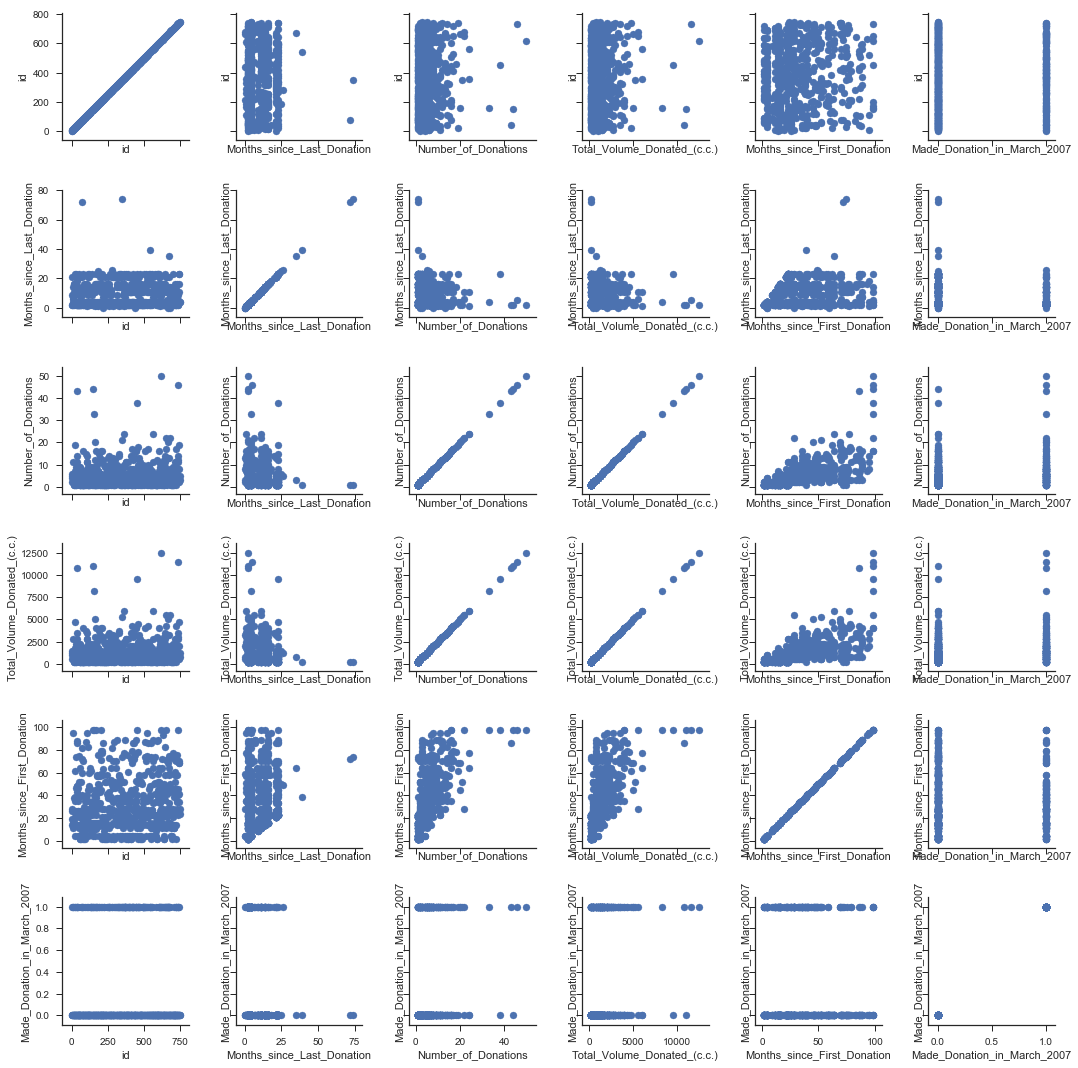

In [33]:
g = sns.PairGrid(raw_data)
g = g.map(plt.scatter)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].xaxis.set_label_text(xlabels[i])
        g.axes[j,i].yaxis.set_label_text(ylabels[j])

plt.show()

### Cleaning up Data

Let’s check for correlations. Perhaps there will be some features that are correlated and could affect any model we create.

In [36]:
corrolations = raw_data.corr()
print(corrolations)

                                   id  Months_since_Last_Donation  \
id                           1.000000                   -0.023217   
Months_since_Last_Donation  -0.023217                    1.000000   
Number_of_Donations          0.063148                   -0.159731   
Months_since_First_Donation  0.098370                    0.186899   
Made_Donation_in_March_2007  0.041925                   -0.261234   

                             Number_of_Donations  Months_since_First_Donation  \
id                                      0.063148                     0.098370   
Months_since_Last_Donation             -0.159731                     0.186899   
Number_of_Donations                     1.000000                     0.622116   
Months_since_First_Donation             0.622116                     1.000000   
Made_Donation_in_March_2007             0.220615                    -0.019819   

                             Made_Donation_in_March_2007  
id                                     

From this we can easily see a direct correlation between Number_of_Donations and Total_Volume_Donated column which makes sense if you think about it so let’s remove the total volume column.

In [35]:
raw_data.drop(['Total_Volume_Donated_(c.c.)'], axis=1, inplace=True)

### Feature Engineering

To hopefully improve the accuracy of the model, I will add some extra features: One which counts the number of donations per month and one for the ratio of last to first donation months.

In [37]:
raw_data['donations_per_month'] = raw_data['Number_of_Donations']/raw_data['Months_since_First_Donation']
raw_data['tenure_ratio'] = raw_data['Months_since_Last_Donation']/raw_data['Months_since_First_Donation']

### Model Baselines

So we can test the accuracy of the model once it is defined, we will create a validation set.

In [39]:
# Split-out validation dataset
input_data = raw_data[['Months_since_Last_Donation', 'Number_of_Donations','Months_since_First_Donation','donations_per_month','tenure_ratio']]
class_data = raw_data['Made_Donation_in_March_2007']
X = input_data.values.astype(float)
Y = class_data.values
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y, test_size=validation_size, random_state=seed)

Here we set up our test harness where we will do 10 fold cross validation. Also, since this competition is being judged on logLoss we set that up as our scoring metric.

In [40]:
# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
seed = 7
scoring = 'log_loss'

To start we will spot check Logistic Regression, Linear Discriminant Analysis, K Nearest Neighbors, Gaussian Naive Bayes, and a Support Vector machine.

In [43]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))

results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.505889 (0.058115)
LDA: -0.506387 (0.060031)
KNN: -2.542005 (0.657964)
NB: -0.695691 (0.337030)
SVM: -0.527873 (0.064335)


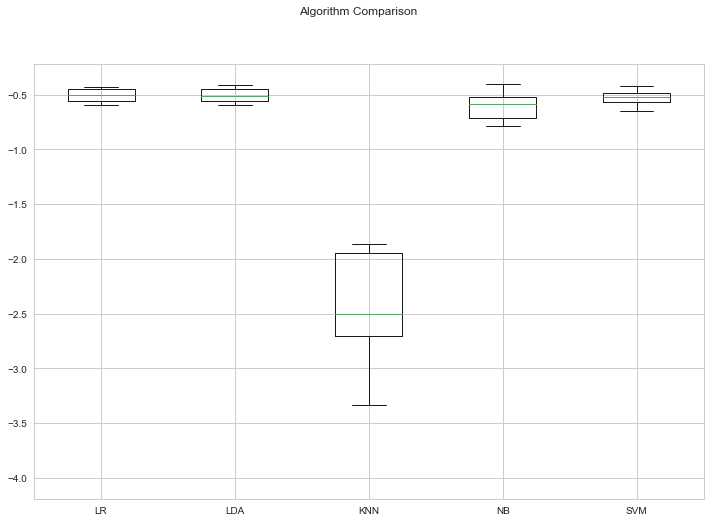

In [44]:
# Compare Algorithms
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Based on this box plot, we should drop the K Nearest Neighbor algorithm from the tests.

Next, we will check to see if scaling will make a difference to the remaining algorithms.

### Scaling

In [48]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',
LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(probability=True))])))
results = []
names = []
for name, model in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold,
    scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.505171 (0.058061)
ScaledLDA: -0.506387 (0.060031)
ScaledNB: -0.695693 (0.337030)
ScaledSVM: -0.519114 (0.059808)


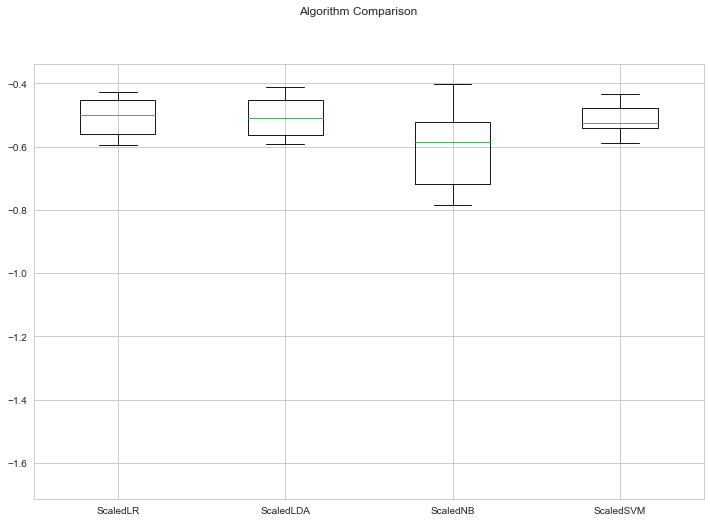

In [50]:
# Compare Algorithms
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From this boxplot, the scaled logistic regression, LDA and SVM algorithms have comparable log loss values. I wonder what we can squeeze out of the SVM with a little tuning.

### Tuning SVM

In [52]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC(probability=True)
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.514689 using {'kernel': 'rbf', 'C': 2.0}
-0.544970 (0.044578) with: {'kernel': 'linear', 'C': 0.1}
-0.567611 (0.065907) with: {'kernel': 'poly', 'C': 0.1}
-0.524069 (0.053174) with: {'kernel': 'rbf', 'C': 0.1}
-0.556894 (0.060216) with: {'kernel': 'sigmoid', 'C': 0.1}
-0.557759 (0.058848) with: {'kernel': 'linear', 'C': 0.3}
-0.588035 (0.126025) with: {'kernel': 'poly', 'C': 0.3}
-0.527239 (0.049788) with: {'kernel': 'rbf', 'C': 0.3}
-0.552079 (0.061133) with: {'kernel': 'sigmoid', 'C': 0.3}
-0.550612 (0.054733) with: {'kernel': 'linear', 'C': 0.5}
-0.556299 (0.059592) with: {'kernel': 'poly', 'C': 0.5}
-0.521685 (0.058919) with: {'kernel': 'rbf', 'C': 0.5}
-0.553119 (0.069235) with: {'kernel': 'sigmoid', 'C': 0.5}
-0.553566 (0.051514) with: {'kernel': 'linear', 'C': 0.7}
-0.563182 (0.071837) with: {'kernel': 'poly', 'C': 0.7}
-0.520014 (0.058967) with: {'kernel': 'rbf', 'C': 0.7}
-0.549959 (0.059751) with: {'kernel': 'sigmoid', 'C': 0.7}
-0.552722 (0.056138) with: {'kernel': 

The results from this SVM grid search are not better than the logistic regression so for the final model we will use that algorithm.

### Final Model

Here we will prepare the final logistic regression model and check against our validation set.

In [53]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = LogisticRegression()
model.fit(rescaledX, Y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict_proba(rescaledValidationX)
print(log_loss(Y_validation, predictions))

0.403941052787


### Make Prediction and Submit for Scoring

Now we can make a prediction using the Driven Data test data and submit to the site for scoring.

In [56]:
test_data = pd.read_csv('C:\\Users\\green\\Documents\\udacity\\deep-learning-master\\intro-to-rnns//blood_donation_train.csv')
test_data.columns.values[0] = 'id'  # Rename the first column (unnamed)
test_data.columns = test_data.columns.str.replace(' ', '_')  # Replace the spaces in the col names.
test_data.drop(['Total_Volume_Donated_(c.c.)'], axis=1, inplace=True)
test_data['donations_per_month'] = test_data['Number_of_Donations']/test_data['Months_since_First_Donation']
test_data['tenure_ratio'] = test_data['Months_since_Last_Donation']/test_data['Months_since_First_Donation']

In [57]:
input_data = test_data[['Months_since_Last_Donation', 'Number_of_Donations','Months_since_First_Donation','donations_per_month','tenure_ratio']]
X = input_data.values.astype(float)
rescaledValidationX = scaler.transform(X)
predictions = model.predict_proba(rescaledValidationX)

In [59]:
submission_format = pd.read_csv('C:\\Users\\green\\Documents\\udacity\\deep-learning-master\\intro-to-rnns//BloodDonationSubmissionFormat.csv')  # Read in the submission format
col_names = submission_format.columns
col_names = ['',col_names[1]]
submission = pd.DataFrame(test_data['id'])
submission['pred'] = predictions[:, 1].tolist()
submission.columns = col_names
submission.to_csv('C:\\Users\\green\\Documents\\udacity\\deep-learning-master\\intro-to-rnns//submission1.csv', index=False)